In [2]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Resize, ToPILImage, ToTensor


from datasets import load_dataset, load_from_disk
import os 

import random



torch.manual_seed(0);

## Karpathy Rules
- Fix random seed
- Cut out bells and whistles like data augmentation
- Very loss at initalisation 
- Initialise the network well 
- Have a Human baseline, e.g: Accuracy
- Overfit a single batch of data
- Verify decreasing training loss

# The Data

In [25]:
downloaded = os.path.exists('../data/tiny_imagenet/')
if not downloaded:
    tiny_imagenet = load_dataset('Maysee/tiny-imagenet', split='train')
    tiny_imagenet.save_to_disk('../data/tiny_imagenet/')
else:
    tiny_imagenet = load_from_disk('../data/tiny_imagenet/')

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

In [26]:
batch_size = 64
tiny_imagenet.set_format(type='torch', columns=['image', 'label'])
train_dataloader = DataLoader(tiny_imagenet.with_format("torch"), batch_size=batch_size)

for batch in train_dataloader:
    X = batch['image']
    y = batch['label']
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 64, 64, 3])
Shape of y: torch.Size([64]) torch.int64


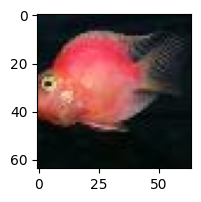

In [20]:

img = batch['image'][random.randint(0, 63)].permute(2, 0, 1)


plt.figure(figsize=(2, 2))  # size is in inches
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

# The Network

In [11]:
device = "cpu"

# torch.nn.LocalResponseNorm

#  Response-normalization layers follow the first and second convolutional layers. 
#  Max-pooling layers follow both response-normalization layers as well as the fifth convolutional layer. 
#  The ReLU non-linearity is applied to the output of every convolutional and fully-connected layer.

from dataclasses import dataclass
@dataclass 
class LocalResonseNormParams:
    size: int = 5
    alpha: float = 0.0001
    beta: float = 0.75
    k: float = 2


class AlexNet(nn.Module):
    # Inputs are 64*64*3
    # For now forgot about the data augmentation, random cropping they do in the paper.

    def __init__(self, norm_params: LocalResonseNormParams):
        super().__init__() 
        self.conv_stack = nn.Sequential(
            # 1st Convolutional Layer
            nn.Conv2d(in_channels = 3, out_channels=96, kernel_size=11, stride=1, padding=1),
            nn.ReLU(),
            nn.LocalResponseNorm(size=norm_params.size, alpha=norm_params.alpha, beta=norm_params.beta, k=norm_params.k),
            nn.MaxPool2d(kernel_size=3, stride=2),


            # 2nd Convolutional Layer
            nn.Conv2d(in_channels = 1, out_channels=128, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.LocalResponseNorm(size=norm_params.size, alpha=norm_params.alpha, beta=norm_params.beta, k=norm_params.k),
            nn.MaxPool2d(kernel_size=3, stride=2),


            # 3rd Convolutional Layer
            nn.Conv2d(in_channels = 1, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # 4th Convolutional Layer
            nn.Conv2d(in_channels = 1, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # 5th Convolutional Layer
            nn.Conv2d(in_channels = 1, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )

        
        self.fc_layer = nn.Sequential(
            # 1st Fully Connected Layer
            nn.Linear(2048, 2048), # Number of pixels, number of outputs. 
            nn.ReLU(),
            nn.Dropout(p=0.5),

            # 2nd Fully Connected Layer
            nn.Linear(2048, 2048), # Number of pixels, number of outputs. 
            nn.ReLU(),
            nn.Dropout(p=0.5),

            # 3rd Fully Connected Layer
            nn.Linear(2048, 200),
            
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.fc_layer(x)
        return logits 

model = AlexNet(norm_params=LocalResonseNormParams()).to(device)
print(model)

AlexNet(
  (conv_stack): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(1, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(1, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0

## The Optimizer

In [14]:
@dataclass
class TrainingParams:
    batch_size: int = 64
    epochs: int = 1
    learning_rate: float = 0.01
    momentum: float = 0.9
    weight_decay: float = 0.0005


training_params = TrainingParams()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    momentum=training_params.momentum
    , lr=training_params.learning_rate
    , weight_decay=training_params.weight_decay
    , params=model.parameters()
    )

## Training Loop

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


for t in range(training_params.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


AttributeError: 'str' object has no attribute 'to'